In [1]:
import pandas as pd
import re
from pyecharts import Map, Geo
import numpy as np
import seaborn as sns
from sklearn.ensemble import AdaBoostRegressor
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

sns.set()
sns.set(font='SimHei')

In [2]:
dataSet = pd.read_csv('lianjia.csv')
dataSet = dataSet.drop('id', axis=1).drop('title', axis=1)

In [3]:
dataSet.describe()

,area,room,hall,toilet,floor,price
count,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000,1969.000000
mean,78.596242,1.876079,1.314373,1.204672,14.394109,8200.349416
std,41.203096,0.796895,0.615849,0.440872,10.115245,6340.943219
min,20.000000,1.000000,0.000000,1.000000,3.000000,1500.000000
25%,48.000000,1.000000,1.000000,1.000000,6.000000,4500.000000
50%,68.000000,2.000000,1.000000,1.000000,8.000000,6300.000000
75%,100.000000,2.000000,2.000000,1.000000,23.000000,10000.000000
max,455.000000,7.000000,4.000000,5.000000,49.000000,130000.000000


In [4]:
dataSet.head(10)

,region,sub_region,area,location,room,hall,toilet,brand,time,layer,floor,price,tenancy,tag
0,徐汇,徐家汇,40.0,南,1,1,1,门店优选,2个月前发布,高楼层,7,4000.0,元/月,近地铁_随时看房
1,长宁,中山公园,52.0,南西南,1,2,1,链家,27天前发布,高楼层,36,11000.0,元/月,近地铁_精装_随时看房
2,徐汇,田林,122.0,南,2,2,1,门店优选,1个月前发布,中楼层,29,8450.0,元/月,近地铁_精装_随时看房
3,徐汇,徐家汇,96.0,南,2,2,1,门店优选,2个月前发布,中楼层,32,12900.0,元/月,近地铁_精装_随时看房
4,浦东,洋泾,50.0,南,2,1,1,链家,26天前发布,中楼层,6,4500.0,元/月,近地铁_随时看房
5,徐汇,田林,68.0,南,2,1,1,门店优选,1个月前发布,高楼层,6,8000.0,元/月,近地铁_精装_随时看房
6,徐汇,徐家汇,34.0,南,1,1,1,门店优选,1个月前发布,中楼层,6,4000.0,元/月,近地铁_精装_随时看房
7,徐汇,徐家汇,40.0,南,1,1,1,链家,26天前发布,低楼层,6,4800.0,元/月,近地铁_精装_随时看房
8,徐汇,田林,88.0,南,2,1,1,门店优选,1个月前发布,低楼层,29,7600.0,元/月,近地铁_随时看房
9,徐汇,徐家汇,37.0,南,1,0,1,门店优选,1个月前发布,中楼层,6,4300.0,元/月,近地铁_随时看房


In [5]:
tag_list = list()
dataSet['tag'] = dataSet['tag'].fillna('无')
dataSet['tag'].apply(lambda x:tag_list.extend(x.split('_')))
tag_list = list(set(tag_list))
tag_list

['月租', '随时看房', '近地铁', '新上', '精装', '双卫生间', '无', '押一付一']

In [6]:
df = pd.concat([dataSet, pd.DataFrame(columns=tag_list)], sort=False)
df[tag_list] = df[tag_list].fillna(0)
def set_status(series):
    tag = series['tag'].split('_')
    for t in tag:
        series[t] = 1
    return series

df[tag_list] = df[['tag', *tag_list]].apply(lambda x:set_status(x), axis=1).drop('tag', axis=1)
df = df.drop('tag', axis=1).drop('tenancy', axis=1)
df

,region,sub_region,area,location,room,hall,toilet,brand,time,layer,floor,price,月租,随时看房,近地铁,新上,精装,双卫生间,无,押一付一
0,徐汇,徐家汇,40.0,南,1.0,1.0,1.0,门店优选,2个月前发布,高楼层,7.0,4000.0,0,1,1,0,0,0,0,0
1,长宁,中山公园,52.0,南西南,1.0,2.0,1.0,链家,27天前发布,高楼层,36.0,11000.0,0,1,1,0,1,0,0,0
2,徐汇,田林,122.0,南,2.0,2.0,1.0,门店优选,1个月前发布,中楼层,29.0,8450.0,0,1,1,0,1,0,0,0
3,徐汇,徐家汇,96.0,南,2.0,2.0,1.0,门店优选,2个月前发布,中楼层,32.0,12900.0,0,1,1,0,1,0,0,0
4,浦东,洋泾,50.0,南,2.0,1.0,1.0,链家,26天前发布,中楼层,6.0,4500.0,0,1,1,0,0,0,0,0
5,徐汇,田林,68.0,南,2.0,1.0,1.0,门店优选,1个月前发布,高楼层,6.0,8000.0,0,1,1,0,1,0,0,0
6,徐汇,徐家汇,34.0,南,1.0,1.0,1.0,门店优选,1个月前发布,中楼层,6.0,4000.0,0,1,1,0,1,0,0,0
7,徐汇,徐家汇,40.0,南,1.0,1.0,1.0,链家,26天前发布,低楼层,6.0,4800.0,0,1,1,0,1,0,0,0
8,徐汇,田林,88.0,南,2.0,1.0,1.0,门店优选,1个月前发布,低楼层,29.0,7600.0,0,1,1,0,0,0,0,0
9,徐汇,徐家汇,37.0,南,1.0,0.0,1.0,门店优选,1个月前发布,中楼层,6.0,4300.0,0,1,1,0,0,0,0,0


# 数据可视化

In [7]:
def get_region(region):
    if region == '浦东':
        return "浦东新区"
    return region + '区'
region = df['region'].value_counts().reset_index()
region['index'] = region['index'].apply(lambda x: get_region(x))
region.describe()

,region
count,15.000000
mean,131.266667
std,117.931861
min,1.000000
25%,68.000000
50%,103.000000
75%,156.500000
max,465.000000


In [8]:
from pyecharts import Geo

geo = Geo("上海各区租房数量信息热点图", "data from lianjia", title_color="#000", title_pos="center", width=900, height=300, background_color='#E6E6FA')

geo.add("",region['index'],region['region'], visual_range=[1, 465], maptype='上海', type='heatmap',visual_text_color="#000",symbol_size=15,is_visualmap=True, is_roam=False)
geo.render()
geo

In [9]:
region_price = df.groupby('region')['price'].mean().reset_index()
region_price['region'] = region_price['region'].apply(lambda x: get_region(x))
region_price.describe()

,price
count,15.000000
mean,7209.458188
std,3336.027812
min,1500.000000
25%,4665.123457
50%,7289.024390
75%,8100.086791
max,14021.359223


In [10]:
from pyecharts import Geo

geo = Geo("上海各区租房平均价格信息热点图", "data from lianjia", title_color="#000", title_pos="center", width=900, height=500, background_color='#F0F8FF')

geo.add("",region_price['region'],region_price['price'], visual_range=[1500, 14000], maptype='上海', type='heatmap',visual_text_color="#000", symbol_size=15, is_visualmap=True, is_roam=False)
geo.render()
geo

In [11]:
region

,index,region
0,浦东新区,465
1,徐汇区,290
2,长宁区,194
3,普陀区,177
4,闵行区,136
5,杨浦区,128
6,静安区,111
7,黄浦区,103
8,闸北区,88
9,虹口区,82


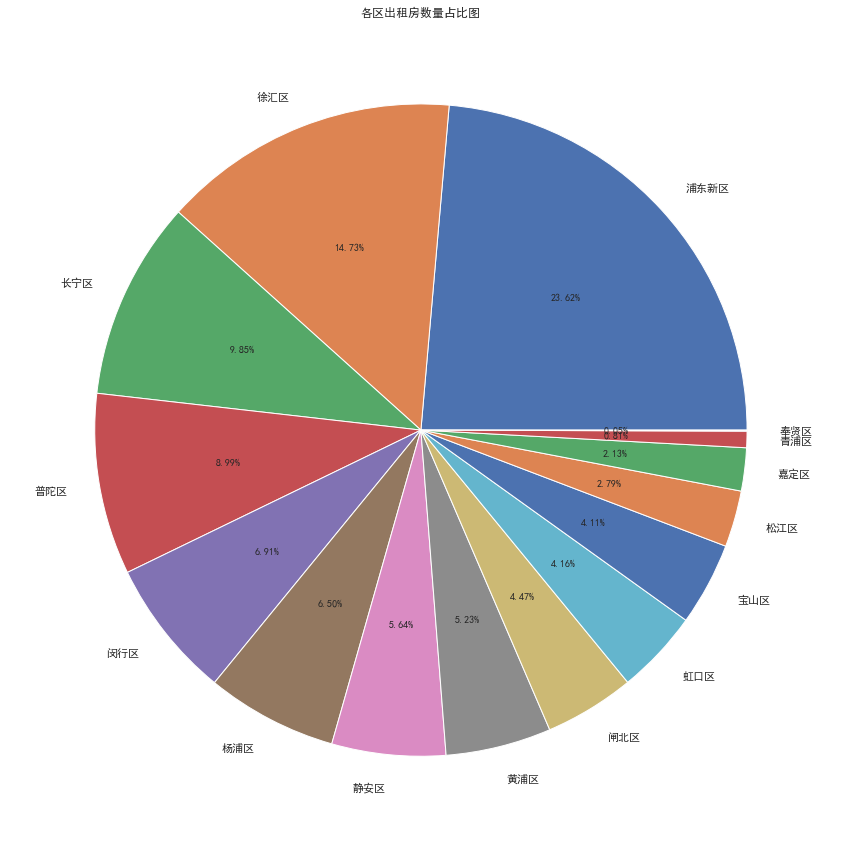

In [12]:
fig = plt.figure(figsize=(15, 15))
region['region']
plt.pie(x=region['region'], labels=region['index'], autopct='%1.2f%%')
plt.title("各区出租房数量占比图")
plt.show()

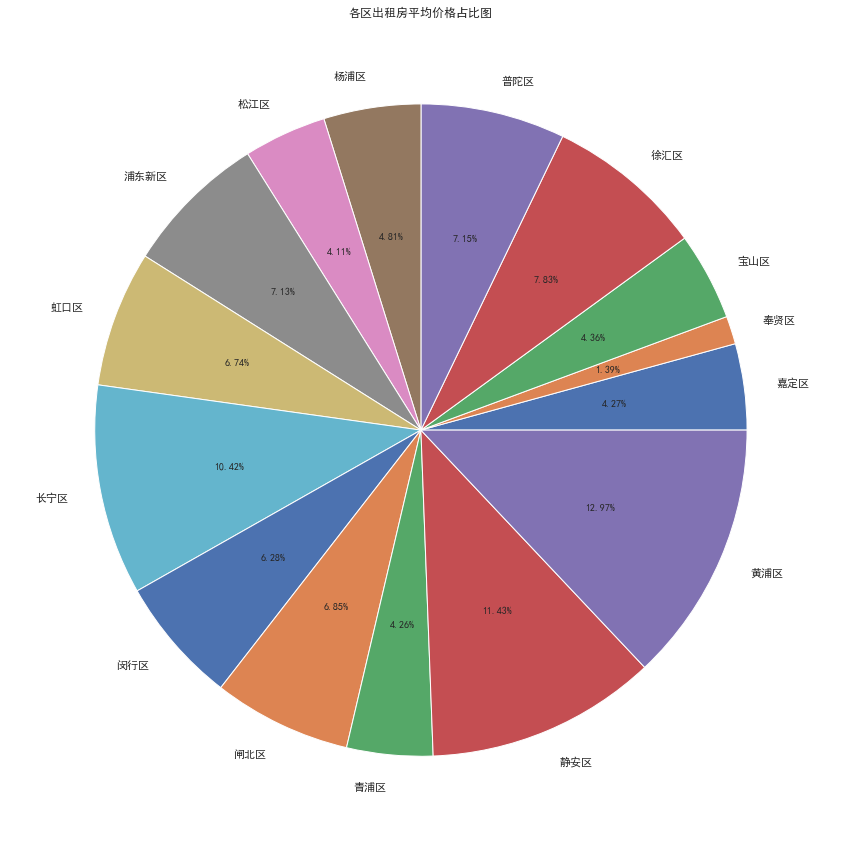

In [13]:
fig = plt.figure(figsize=(15, 15))
plt.pie(x=region_price['price'], labels=region_price['region'], autopct='%1.2f%%')
plt.title("各区出租房平均价格占比图")
plt.show()

In [14]:
mode = re.findall(r'\d+', df['time'].mode().loc[0])[0]

def get_days(string):
    time = re.findall(r'\d+', string)[0] if re.findall(r'\d+', string) else mode
    if '天' in string:
        return int(time)
    else:
        return int(time) * 30
df['time'] = df['time'].apply(lambda x:get_days(x))
df.head(10)

,region,sub_region,area,location,room,hall,toilet,brand,time,layer,floor,price,月租,双卫生间,精装,新上,随时看房,押一付一,近地铁,无
0,徐汇,徐家汇,40.0,南,1.0,1.0,1.0,门店优选,60,高楼层,7.0,4000.0,0,0,0,0,1,0,1,0
1,长宁,中山公园,52.0,南西南,1.0,2.0,1.0,链家,27,高楼层,36.0,11000.0,0,0,1,0,1,0,1,0
2,徐汇,田林,122.0,南,2.0,2.0,1.0,门店优选,30,中楼层,29.0,8450.0,0,0,1,0,1,0,1,0
3,徐汇,徐家汇,96.0,南,2.0,2.0,1.0,门店优选,60,中楼层,32.0,12900.0,0,0,1,0,1,0,1,0
4,浦东,洋泾,50.0,南,2.0,1.0,1.0,链家,26,中楼层,6.0,4500.0,0,0,0,0,1,0,1,0
5,徐汇,田林,68.0,南,2.0,1.0,1.0,门店优选,30,高楼层,6.0,8000.0,0,0,1,0,1,0,1,0
6,徐汇,徐家汇,34.0,南,1.0,1.0,1.0,门店优选,30,中楼层,6.0,4000.0,0,0,1,0,1,0,1,0
7,徐汇,徐家汇,40.0,南,1.0,1.0,1.0,链家,26,低楼层,6.0,4800.0,0,0,1,0,1,0,1,0
8,徐汇,田林,88.0,南,2.0,1.0,1.0,门店优选,30,低楼层,29.0,7600.0,0,0,0,0,1,0,1,0
9,徐汇,徐家汇,37.0,南,1.0,0.0,1.0,门店优选,30,中楼层,6.0,4300.0,0,0,0,0,1,0,1,0


In [15]:
one_hot_list = pd.get_dummies(df[['region', 'sub_region', 'location', 'brand', 'layer']])
df_result = df.drop('region', axis=1).drop('sub_region', axis=1).drop('location', axis=1).drop('brand', axis=1).drop('layer', axis=1)
df_result = pd.merge(df_result, one_hot_list, left_index=True, right_index=True)
df_result.head(10)

,area,room,hall,toilet,time,floor,price,月租,双卫生间,精装,...,location_西,location_西北,location_西北北,location_西南,location_西南西,brand_链家,brand_门店优选,layer_中楼层,layer_低楼层,layer_高楼层
0,40.0,1.0,1.0,1.0,60,7.0,4000.0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,52.0,1.0,2.0,1.0,27,36.0,11000.0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
2,122.0,2.0,2.0,1.0,30,29.0,8450.0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
3,96.0,2.0,2.0,1.0,60,32.0,12900.0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
4,50.0,2.0,1.0,1.0,26,6.0,4500.0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
5,68.0,2.0,1.0,1.0,30,6.0,8000.0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
6,34.0,1.0,1.0,1.0,30,6.0,4000.0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
7,40.0,1.0,1.0,1.0,26,6.0,4800.0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
8,88.0,2.0,1.0,1.0,30,29.0,7600.0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
9,37.0,1.0,0.0,1.0,30,6.0,4300.0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [16]:
X = df_result[df_result.columns.difference(['price'])].values
Y = df_result['price'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [17]:
ada = AdaBoostRegressor(base_estimator=RandomForestRegressor(n_estimators=50), learning_rate=0.0005).fit(X_train, Y_train)
pred = ada.predict(X_test)

pd.DataFrame(np.concatenate((Y_test.reshape(-1,1), pred.reshape(-1,1)),axis=1), columns=['pred', 'Y_test'])

,pred,Y_test
0,4500.0,5598.00
1,4500.0,5786.00
2,4600.0,7274.00
3,4000.0,5037.96
4,15000.0,16529.98
5,4800.0,6442.00
6,9300.0,6834.00
7,14000.0,11634.00
8,4500.0,7094.00
9,3600.0,3472.00


In [18]:
print ("MAE:",metrics.mean_absolute_error(Y_test, pred))

# calculate MSE using scikit-learn
print ("MSE:",metrics.mean_squared_error(Y_test, pred))

# calculate RMSE using scikit-learn
print ("RMSE:",np.sqrt(metrics.mean_squared_error(Y_test, pred)))

# calculate R2 using scikit-learn
print ("R2:",metrics.r2_score(Y_test, pred))

MAE: 1442.617461928934
MSE: 6542428.348270051
RMSE: 2557.817106102399
R2: 0.8142100632930982
